<a href="https://colab.research.google.com/github/Jming9638/MachineLearning/blob/main/DBSCAN_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython.display import clear_output

!pip install scikit-learn==1.3.2 dataframe-image

clear_output()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from scipy.stats import skew
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.neighbors import NearestNeighbors

In [ ]:
def outlier_checker(data, metric):
    # print(f'Metric: {metric}')
    # row_before = data.shape[0]
    # print(f'Before removing outlier: {row_before}')

    Q1 = data[metric].quantile(0.25)
    Q3 = data[metric].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = int(round(Q1 - 1.5 * IQR, 0))
    upper_bound = int(round(Q3 + 1.5 * IQR, 0))

    # data = data[(data[metric] >= lower_bound) & (data[metric] <= upper_bound)]

    # row_after = data.shape[0]
    # print(f'After removing outlier: {row_after}')
    # print(f'Total removed: {row_before - row_after}')

    # print(f'Lower Boundary: {lower_bound}\nUpper Boundary: {upper_bound}')
    # print()
    return [metric, lower_bound, upper_bound]

In [ ]:
data = pd.read_csv('./drive/MyDrive/Bonuslink/FMD_Bonuslink3.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   memberid                                646 non-null    int64  
 1   blcard                                  646 non-null    int64  
 2   merchantid                              646 non-null    int64  
 3   outletid                                646 non-null    int64  
 4   count_of_orders                         646 non-null    int64  
 5   total_revenue                           646 non-null    float64
 6   total_points                            646 non-null    int64  
 7   total_cashback_received                 646 non-null    float64
 8   count_of_orders_with_cashback_received  646 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 45.5 KB


In [ ]:
data = pd.read_csv('./drive/MyDrive/Bonuslink/FMD_Bonuslink3.csv')
data = data.astype({'memberid': 'str', 'blcard': 'str', 'merchantid': 'str', 'outletid': 'str'})
data = data.set_index(['memberid', 'blcard', 'merchantid', 'outletid'])
data = data.fillna(0)
print('Total rows:', data.shape[0])
data.head()

Total rows: 646


,,,,count_of_orders,total_revenue,total_points,total_cashback_received,count_of_orders_with_cashback_received
memberid,blcard,merchantid,outletid,,,,,
1236992,6018840166666061,4237,11785,524,12711.0400,2582,6667.1400,523
81749,6018840152354342,4237,11785,243,6645.3500,2576,3366.8900,241
1225827,6018840166424370,2316,9686,230,6119.2800,0,3409.3200,229
1263320,6018840167239355,2139,9503,219,2890.5000,0,1366.4000,217
1228504,6018840166477667,2316,9686,201,5616.8100,0,3289.0900,199


In [ ]:
data = data.astype({'count_of_orders': 'int', 'total_revenue': 'float', 'total_points': 'int', 'total_cashback_received': 'float', 'count_of_orders_with_cashback_received': 'int'})

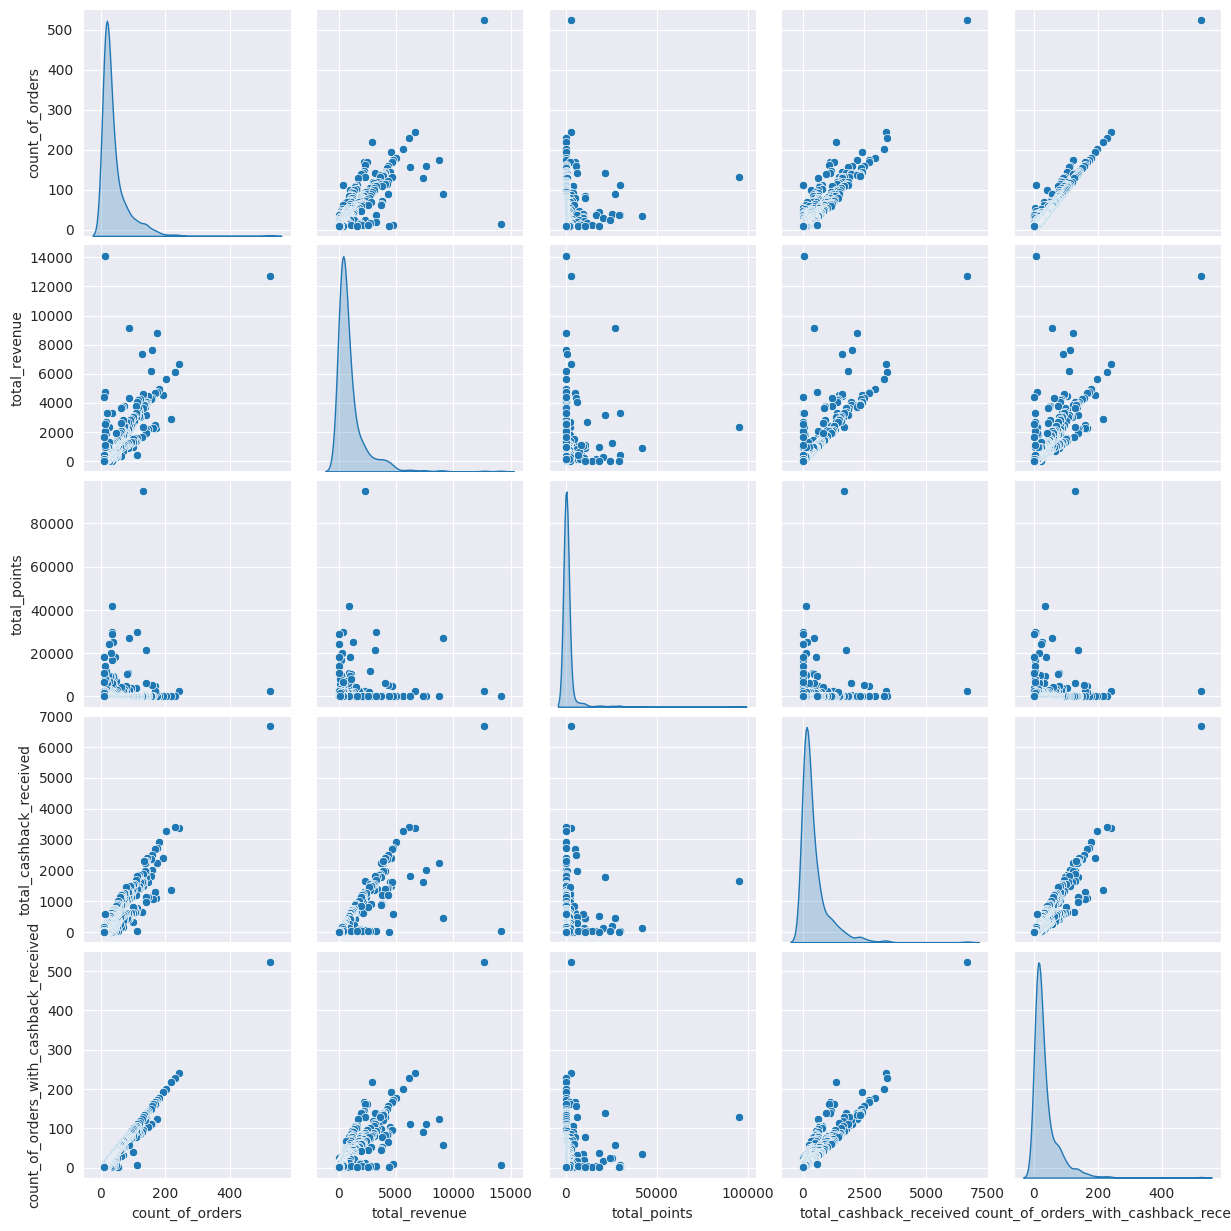

In [ ]:
sns.pairplot(data=data, diag_kind='kde')
plt.show()

In [ ]:
def custom_format(x):
    if x == int(x):
        return '{:.0f}'.format(x)
    else:
        return '{:.4f}'.format(x)
pd.set_option('display.float_format', custom_format)
sns.set_style('darkgrid')
data.describe()

,count_of_orders,total_revenue,total_points,total_cashback_received,count_of_orders_with_cashback_received
count,646,646,646,646,646
mean,40.0867,1024.3653,1130.6625,455.0665,35.3885
std,42.7453,1400.4025,5322.7183,590.2459,41.2989
min,10,0,0,1,1
25%,15,281.1375,0,112,12
50%,24,504.9500,0,240.1400,20
75%,47,1134.4175,0,564.5000,43
max,524,14122.6000,95022,6667.1400,523


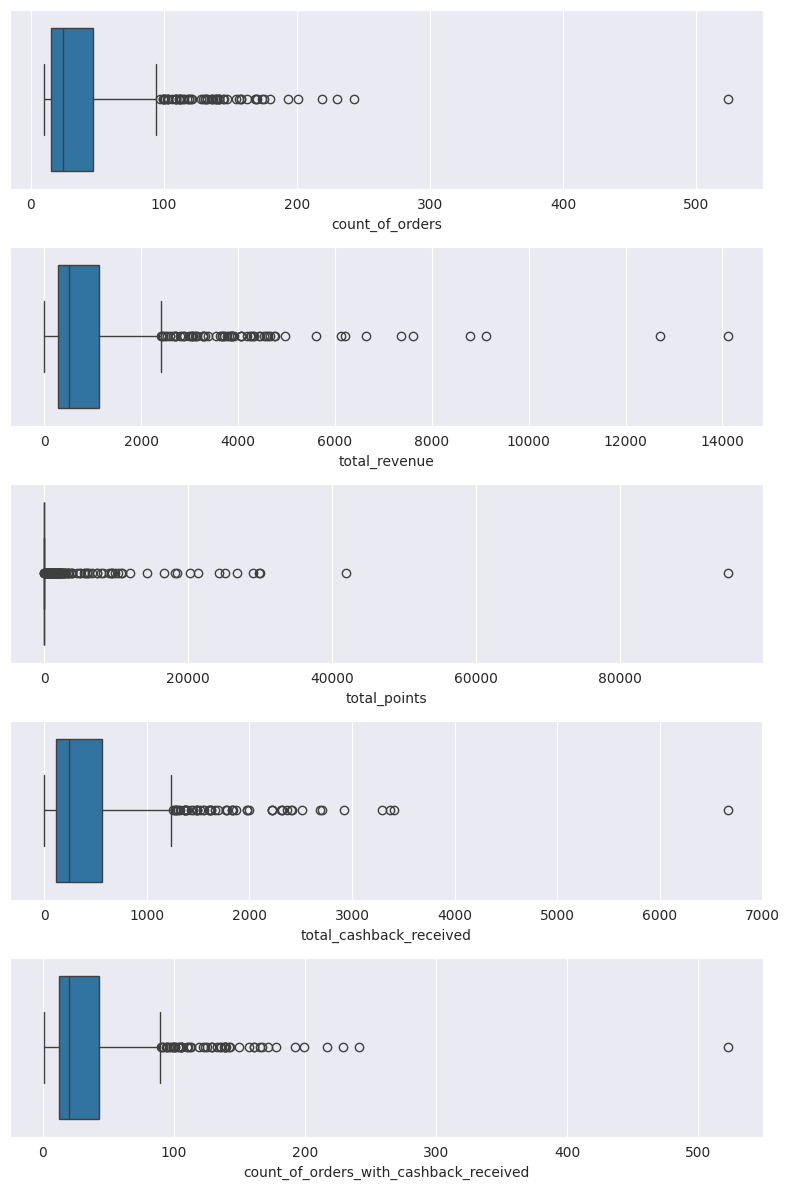

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(8, 12))

columns_to_plot = data.columns.tolist()
for i, col in enumerate(columns_to_plot):
    sns.boxplot(x=data[col], ax=axes[i])

plt.tight_layout()
plt.show()

In [ ]:
boundaries = []
for col in columns_to_plot:
    boundaries.append(outlier_checker(data, col))

# dfi.export(pd.DataFrame(boundaries, columns=['metrics', 'lower', 'upper']).style.hide(axis='index'), './boundaries.png', table_conversion='matplotlib', dpi=150)
pd.DataFrame(boundaries, columns=['metrics', 'lower', 'upper'])

,metrics,lower,upper
0,count_of_orders,-33,95
1,total_revenue,-999,2414
2,total_points,0,0
3,total_cashback_received,-567,1243
4,count_of_orders_with_cashback_received,-34,90


In [ ]:
train_data = data.drop(['total_points'], axis=1).copy()
# train_data = data.copy()

Maximum numbers of component: 4


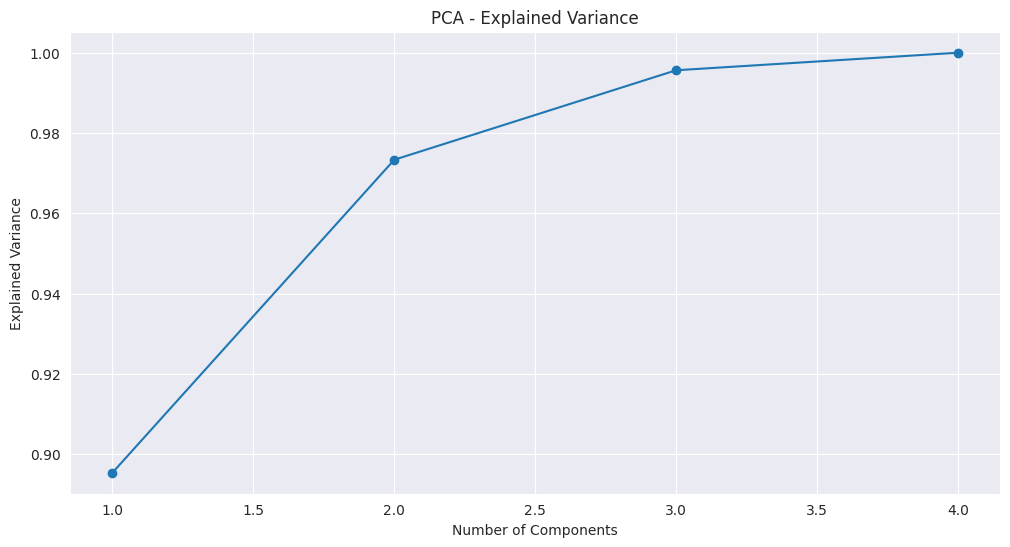

In [ ]:
explained_variance = []
max_component = len(train_data.columns) + 1
print('Maximum numbers of component:', max_component - 1)
n_components_range = range(1, max_component)

scaler = StandardScaler()
X = scaler.fit_transform(train_data)

for n_components in n_components_range:
    pca = PCA(n_components=n_components)
    pca.fit(X)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(12, 6))
plt.plot(n_components_range, explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA - Explained Variance')
plt.show()

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(train_data)

n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

In [ ]:
min_cluster_size = 20
eps = 10  # maximum distance between two points to be in the same neighborhood
min_samples = 6  # minimum number of points to form a dense region
# dbscan = DBSCAN(eps=eps, min_samples=min_samples)
hdbscan = HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    cluster_selection_epsilon=eps,
    n_jobs=-1
)
labels = hdbscan.fit_predict(X_pca)

anomalies = X_pca[labels == -1]

score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.44280166670000365


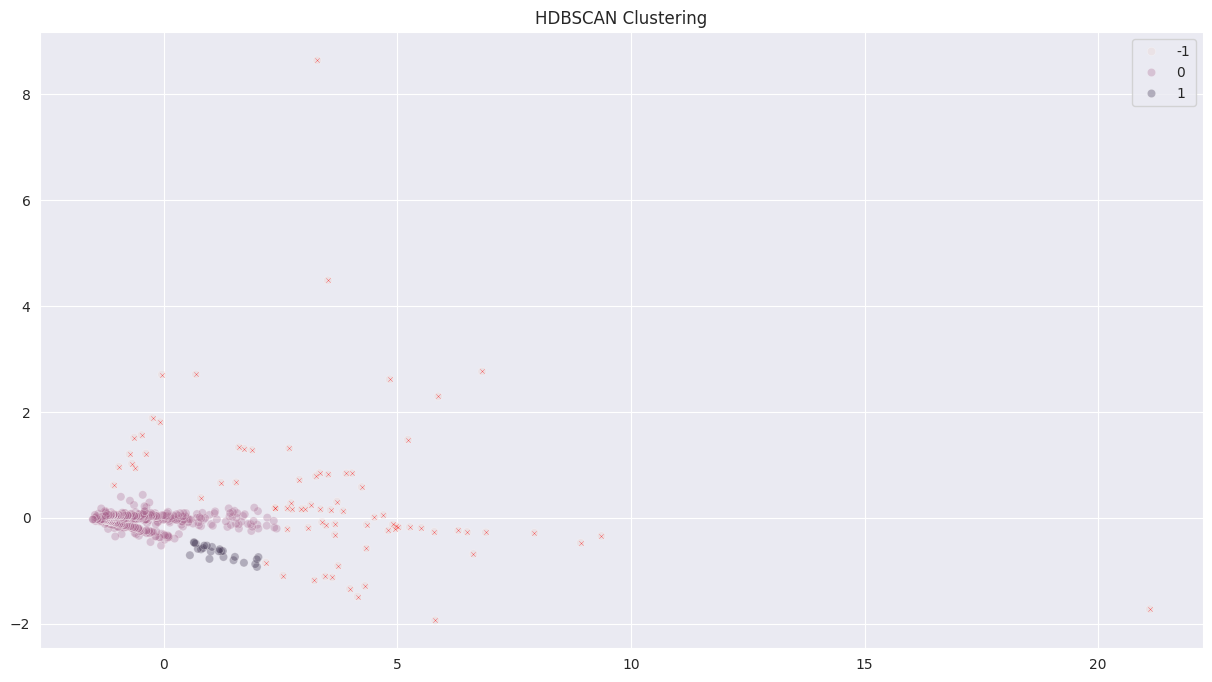

In [ ]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels,
    alpha=0.3
)
sns.scatterplot(
    x=anomalies[:, 0],
    y=anomalies[:, 1],
    color='red',
    marker='x',
    s=10,
    alpha=0.7
)

plt.title("HDBSCAN Clustering")
plt.legend(loc='best')
plt.show()

In [ ]:
data['label'] = labels
data[(data['label'] == -1)]

,,,,count_of_orders,total_revenue,total_points,total_cashback_received,count_of_orders_with_cashback_received,label
memberid,blcard,merchantid,outletid,,,,,,
1236992,6018840166666061,4237,11785,524,12711.0400,2582,6667.1400,523,-1
81749,6018840152354342,4237,11785,243,6645.3500,2576,3366.8900,241,-1
1225827,6018840166424370,2316,9686,230,6119.2800,0,3409.3200,229,-1
1263320,6018840167239355,2139,9503,219,2890.5000,0,1366.4000,217,-1
1228504,6018840166477667,2316,9686,201,5616.8100,0,3289.0900,199,-1
...,...,...,...,...,...,...,...,...,...
921875,6018840118891668,657,7519,12,2079.6000,0,34.4000,5,-1
247507,6018840138285214,654,7513,12,1112.4800,8112,26.4000,4,-1
57680,6018840006972422,888,8148,12,2533,0,16,2,-1


In [ ]:
data[(data['label'] == -1)].drop(['label'], axis=1).describe()

,count_of_orders,total_revenue,total_points,total_cashback_received,count_of_orders_with_cashback_received
count,80,80,80,80,80
mean,115.6125,3889.2710,2781.4750,1484.6285,103.4625
std,72.1211,2163.7184,11697.9781,1023.4904,74.5381
min,10,1112.4800,0,10.4000,2
25%,83.5000,2689.0875,0,907.5000,63
50%,118,3464.7500,0,1485.0650,100
75%,141.7500,4320.0875,0,1899.9150,138.2500
max,524,14122.6000,95022,6667.1400,523


In [ ]:
data[(data['label'] == -1)].to_csv('./without_total_points_results.csv')

In [ ]:
data[(data['label'] == -1)].reset_index()['blcard'].nunique()

71

In [ ]:
# dfi.export(data[(data['label'] == -1)].drop(['label'], axis=1).describe(), './without_total_points_describe.png', table_conversion='matplotlib', dpi=150)

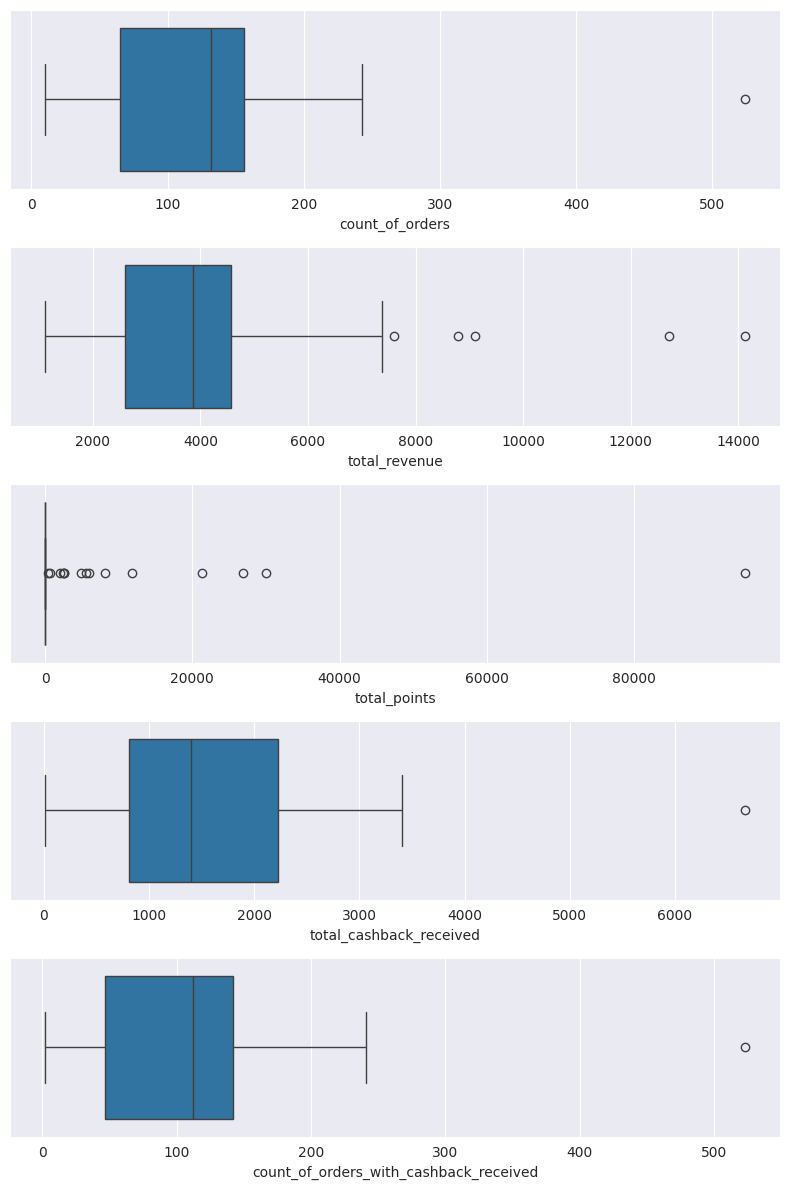

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(8, 12))
for i, col in enumerate(columns_to_plot):
    sns.boxplot(x=data[(data['label'] == -1)].drop(['label'], axis=1)[col], ax=axes[i])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

X = data.drop('label', axis=1)
y = data['label']

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Model accuracy: {score}%'.format(score=round(accuracy_score(y_test, y_pred) * 100, 2)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model accuracy: 94.62%
[[ 16   3   0]
 [  3 101   0]
 [  1   0   6]]
              precision    recall  f1-score   support

          -1       0.80      0.84      0.82        19
           0       0.97      0.97      0.97       104
           1       1.00      0.86      0.92         7

    accuracy                           0.95       130
   macro avg       0.92      0.89      0.90       130
weighted avg       0.95      0.95      0.95       130

